In [9]:
import functools

import numpy as np

import jax
import jax.numpy as jnp
import haiku as hk

import sinusoid_regression_dataset

## Setting up the dataset and prediction function


In [11]:
dataset = sinusoid_regression_dataset.SinusoidRegression(16, 5, 50)

def net(x):
    x = hk.nets.MLP((32, 32, 32, 32, 2))(x)
    mu, stddev = jnp.split(x, 2, -1)
    return mu, stddev

## Plotting

In [53]:
import matplotlib.pyplot as plt


def plot(x, y, x_tst, yhats):
    mus, stddevs = yhats
    plt.figure()  # inches
    for task in range(x.shape[0]):
        plt.subplot(x.shape[0] // 4, 4, task + 1)
        plt.plot(x[task], y[task], "b.", label="observed")
        avgm = np.zeros_like(x_tst[task, :, 0])
        for i, (mu, stddev) in enumerate(zip(mus, stddevs)):
            m = np.squeeze(mu[task])
            s = np.squeeze(stddev[task])
            if i < 15:
                plt.plot(
                    x_tst[task],
                    m,
                    "r",
                    label="ensemble means" if i == 0 else None,
                    linewidth=1.0,
                )
                plt.plot(
                    x_tst[task],
                    m + 3 * s,
                    "g",
                    linewidth=0.5,
                    label="ensemble means + 3 ensemble stdev" if i == 0 else None,
                )
                plt.plot(
                    x_tst[task],
                    m - 3 * s,
                    "g",
                    linewidth=0.5,
                    label="ensemble means - 3 ensemble stdev" if i == 0 else None,
                )
            avgm += m
        plt.plot(x_tst[task], avgm / len(mu[task]), "r", label="overall mean", linewidth=4)
        ax = plt.gca()
        ax.xaxis.set_ticks_position("bottom")
        ax.yaxis.set_ticks_position("left")
        ax.spines["left"].set_position(("data", 0))
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    plt.tight_layout()

## Setting up the model

In [14]:
import models
import optax

init, apply = hk.without_apply_rng(hk.transform(net))
example = next(dataset.train_set)[0][0]
seed_sequence = hk.PRNGSequence(666)
hyper_prior = models.ParamsMeanField(
    jax.tree_map(jnp.zeros_like, init(next(seed_sequence), example))
)
n_particles = 10
init = jax.vmap(init, (0, None))
prior_particles = init(jnp.asarray(seed_sequence.take(n_particles)), example)
prior = models.ParamsMeanField(prior_particles)
opt = optax.flatten(optax.adam(2e-3))
opt_state = opt.init(prior_particles)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/yarden/miniconda3/envs/jax-ml/lib/python3.10/site-packages/haiku/_src/base.py:515: UserWarning: Explicitly requested dtype float64 requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  param = init(shape, dtype)


## Training a model sampled from the hyper-prior

In [45]:
import distrax
import pacoh_nn as pacoh

infer_posteriors = jax.vmap(
    pacoh.infer_posterior, in_axes=(0, 0, None, None, None, None, None)
)

(context_x, context_y), (test_x, test_y) = next(dataset.test_set)
posteriors, losses = infer_posteriors(
    context_x, context_y, prior, apply, next(seed_sequence), 100, 1e-3
)
predict = jax.vmap(pacoh.predict, (0, 0, None))
predictions = predict(posteriors, test_x, apply)

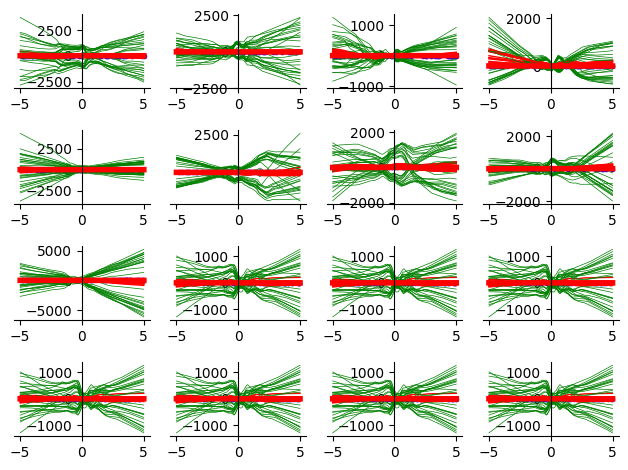

In [54]:
plot(context_x, context_y, test_x, predictions)

## Meta-training

In [9]:

hyper_posterior = pacoh.meta_train(
    dataset.train_set, apply, hyper_prior, prior, opt, opt_state, 1000, 10
)


Iteration 0 log probs: 19389.650390625
Iteration 100 log probs: 61802.5
Iteration 200 log probs: 14641.8818359375
Iteration 300 log probs: 8222.619140625
Iteration 400 log probs: 7071.97021484375
Iteration 500 log probs: 4595.41845703125
Iteration 600 log probs: 8550.48828125
Iteration 700 log probs: 14340.7529296875
Iteration 800 log probs: 6276.17138671875
Iteration 900 log probs: 4453.23193359375


## Posterior(s) inference & Predicition

In [ ]:
(context_x, context_y), (test_x, test_y) = next(dataset.test_set)
infer_posteriors = jax.vmap(
    pacoh.infer_posterior, in_axes=(0, 0, None, None, None, None, None)
)
posteriors, losses = infer_posteriors(
    context_x, context_y, hyper_posterior, apply, next(seed_sequence), 100, 3e-4
)
predict = jax.vmap(pacoh.predict, in_axes=(0, None, None))
predictions = predict(posteriors, test_x, apply)